In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,InputLayer,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy,mean_squared_error,mean_absolute_error
from tensorflow.keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lenc = LabelEncoder()
ohe = OneHotEncoder()

In [2]:
N_CLASSES = 5
IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [5]:
model = Sequential()
model.add(InputLayer(input_shape=IMSIZE))
model.add(Conv2D(64,(5,5),activation='relu',strides=(2,2),padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',strides=(2,2),padding='same'))

model.add(Conv2D(64,(1,1),activation='relu',padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(128,(1,1),activation='relu',padding='same'))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256,(1,1),activation='relu',padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(512,(1,1),activation='relu',padding='same'))
model.add(Conv2D(512,(3,3),activation='relu',padding='same'))
model.add(Conv2D(1024,(3,3),activation='relu',padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(N_CLASSES,activation='softmax'))


In [6]:
model.compile(loss=BinaryCrossentropy(from_logits=False),optimizer='sgd',metrics=Accuracy())

In [7]:
Data = pd.read_csv("gestures.csv")
X,Y = np.array(Data.drop(columns="classes")).reshape(-1,128,128,3), ohe.fit_transform(np.array(Data.classes).reshape(-1,1)).toarray()
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.8)
del X,Y,Data


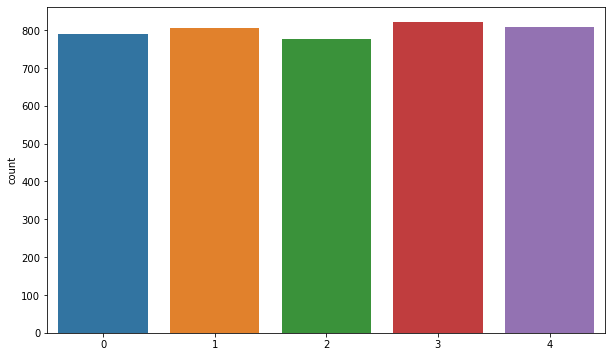

In [8]:
y = ohe.inverse_transform(ytrain)

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [9]:
model.fit(xtrain,ytrain,validation_split=0.2,epochs=20,batch_size=20)

Epoch 1/20


2022-05-21 15:29:07.808596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1258291200 exceeds 10% of free system memory.


160/160 [==============================] - 78s 485ms/step - loss: 0.6540 - accuracy: 0.0000e+00 - val_loss: 0.6129 - val_accuracy: 0.0000e+00
Epoch 2/20
160/160 [==============================] - 76s 478ms/step - loss: 0.5675 - accuracy: 0.0000e+00 - val_loss: 0.5165 - val_accuracy: 0.0000e+00
Epoch 3/20
160/160 [==============================] - 76s 473ms/step - loss: 0.5060 - accuracy: 0.0000e+00 - val_loss: 0.4999 - val_accuracy: 0.0000e+00
Epoch 4/20
160/160 [==============================] - 75s 466ms/step - loss: 0.5031 - accuracy: 0.0000e+00 - val_loss: 0.4987 - val_accuracy: 0.0000e+00
Epoch 5/20
160/160 [==============================] - 75s 471ms/step - loss: 0.5017 - accuracy: 0.0000e+00 - val_loss: 0.4966 - val_accuracy: 0.0000e+00
Epoch 6/20
160/160 [==============================] - 72s 453ms/step - loss: 0.4973 - accuracy: 0.0000e+00 - val_loss: 0.4907 - val_accuracy: 0.0000e+00
Epoch 7/20
160/160 [==============================] - 69s 432ms/step - loss: 0.4894 - accurac

In [10]:
res = model.predict(xtest).round(1)

In [11]:
res_f = ohe.inverse_transform(res)
ytest_f = ohe.inverse_transform(ytest)

In [12]:
print(classification_report(res_f,ytest_f))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       161
           1       0.97      0.73      0.83       261
           2       0.98      0.98      0.98       223
           3       0.96      0.97      0.96       178
           4       0.92      0.99      0.95       177

    accuracy                           0.91      1000
   macro avg       0.91      0.92      0.91      1000
weighted avg       0.92      0.91      0.91      1000



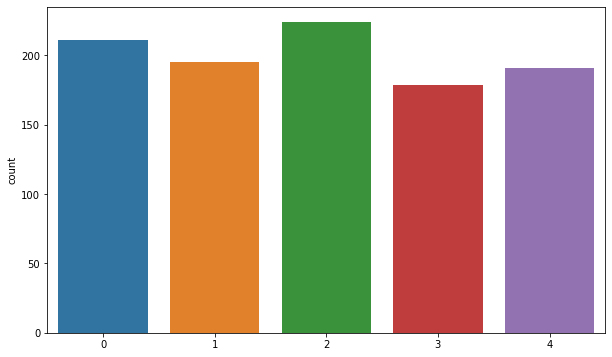

In [13]:
yt = ohe.inverse_transform(ytest)

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=yt.flatten())
plt.show()